# Humans:

Note: for this code to work, the 'data/humans' folder needs to contain one sub-folder for each performed experiment. In each of these folders, the data for the different N must be contained.

In [31]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.special import ndtr
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt, e

In [42]:
class HumanAnalysisPipeline:
    
    def __init__(self, experiment_name, analysis_type="global"):
        self.experiment_name = experiment_name
        if analysis_type not in ["global", "subject-wise"]:
            raise ValueError("analysis_type must be either 'global' or 'subject-wise'")
        self.analysis_type = analysis_type
    
    
    def read_raw_data(self):
        print("|Reading raw data...")
        
        # Creating an empty dataframe that will be populated:
        humans_complete_raw_df = pd.DataFrame()

        # Define the path to the experiment directory:
        experiment_path = Path(f'./data/humans/{self.experiment_name}')

        if not experiment_path.exists():
            print(f"Experiment directory {experiment_path} does not exist.")
            return

        # Accessing all folders in the specified directory:
        folders = experiment_path.glob('*')
                
        for folder in folders:
            if folder.is_dir():
                print(f"||Entered folder: {folder}")
                
                # Accessing all CSV files in the specified directory:
                files = folder.glob('*.csv')
                
                for file_index, file in enumerate(files):
                    if file.is_file():
                        print(f"|||Reading file: {file}")
                        
                        try:
                            # Reading the CSV file:
                            df = pd.read_csv(file)

                            # Concatenating the dataframes:
                            if self.analysis_type == "subject-wise":
                                df['subject_number'] = file_index + 1   # Assigning a subject number to each file
                                
                                #NOTE: assign subject id instead of number?
                                
                            humans_complete_raw_df = pd.concat([humans_complete_raw_df, df], axis=0, ignore_index=True)
                            
                        except Exception as e:
                            print(f"Error reading file {file}: {e}")
        
        self.humans_complete_raw_df = humans_complete_raw_df
        
        print(self.humans_complete_raw_df)
        
        print("|Completed reading raw data.")
    
    
    
    def calculate_demographics(self):
        print("|Calculating demographics.")

        # isolating survey trials to calculate average age:
        humans_300_survey = self.humans_complete_raw_df[self.humans_complete_raw_df.trial_type == "survey-html-form"]
        # initializations:
        age = []
        female_count = 0
        # accessing ages and storing them:
        for index, row in humans_300_survey.iterrows():
            print(row.response)
            
            try:
                # reading age -> 3rd and 4th to last element of "response" string (includes gender and age)
                age.append(int(row.response[-4:-2]))
            except ValueError:
                print(f"Error reading age for row {index}: Invalid age format")
            
            # incrementing female count:
            if row.response[11:13] == "fe":
                female_count += 1
        
        # calculating average age and total female count:
        try:
            average_age = np.mean(age)
            print(f"Average age: {average_age}")
        except ZeroDivisionError:
            print("Error calculating average age: No valid age data found")
        
        print(f"Female count: {female_count}")
        
        print("|Completed calculating demographics.")
            
     
    def clean_data(self):
        print("|Cleaning data...")
        
        try:
            # cleaning raw data to access only relevant variables:
            # - isolating experiment trials ("canvas-keyboard-response" ones) and dropping irrelevant variables:
            cleaned_df = self.humans_complete_raw_df[self.humans_complete_raw_df.trial_type == "canvas-keyboard-response"]
            # - dropping irrelevant variables:
            cleaned_df = cleaned_df.drop(["timeout","failed_images","failed_audio","failed_video","view_history","trial_index", "time_elapsed","internal_node_id" ,"success","stimulus","graphs_couple"], axis=1).copy()
            # - isolating trials were final responses were given (shuffles have " " as response):
            self.cleaned_data = cleaned_df[cleaned_df['response'].isin(['arrowright','arrowleft'])]
            print(self.cleaned_data)
            print("|Completed cleaning data.")
        except Exception as e:
            print(f"Error cleaning data: {e}")
        
        print("|Completed cleaning data.")
        
        
    def calculate_fraction_correct(self):
        print("|Calculating fraction correct...")
            
        # initializations:
        df_humans_fraction_correct_appended = []
        N_values = self.cleaned_data['graph_size'].unique()
        for N_value in N_values:
            # isolating data of current N value:
            currentN_data = self.cleaned_data[self.cleaned_data.graph_size == N_value]
            # isolating the single values of K:
            K_range = currentN_data['clique_size'].unique()
            for K_value in K_range:
                
                if self.analysis_type == "global":
                    # isolating data of current clique size:
                    currentK_data = currentN_data[currentN_data.clique_size == K_value]
                    # calculating accuracy for current clique size ("correct", when present, is either True or False)
                    fraction_correct_currentK = sum(currentK_data.correct) / sum(~ currentK_data.correct.isna())
                    # appending data to the list:
                    df_humans_fraction_correct_appended.append(pd.DataFrame({'N':[N_value], 'K':[K_value], 'fc':[fraction_correct_currentK]}))
                elif self.analysis_type == "subject-wise":
                    for subject_number in currentN_data['subject_number'].unique():
                        # isolating data of current clique size and subject number:
                        currentK_data = currentN_data[(currentN_data.clique_size == K_value) & (currentN_data.subject_number == subject_number)]
                        # calculating accuracy ("correct", when present, is either True or False)
                        fraction_correct_currentK = sum(currentK_data.correct) / sum(~ currentK_data.correct.isna())
                        # appending data to the list:
                        df_humans_fraction_correct_appended.append(pd.DataFrame({'subject_number':[subject_number],'N':[N_value], 'K':[K_value], 'fc':[fraction_correct_currentK]}))
                else:
                    raise ValueError("Invalid analysis type")

        # creating single df for current N value:   
        df_humans_fraction_correct = pd.concat(df_humans_fraction_correct_appended)
        # creating new variable and adding it to the dataframe:
        df_humans_fraction_correct['K/sqrt(N)'] = df_humans_fraction_correct['K']/np.sqrt(df_humans_fraction_correct['N'])
        # creating new variable and adding it to the dataframe:
        df_humans_fraction_correct['K/N'] = df_humans_fraction_correct['K']/df_humans_fraction_correct['N']
        # saving dataframe:
        self.df_humans_fraction_correct = df_humans_fraction_correct
        # visualizing dataframe:
        display(df_humans_fraction_correct)  
        print("|Completed calculating fraction correct.")      
        
    # def calculate_shuffles(self):
    # TODO: perform analysis on the number of shuffles (starting from raw data)                       
            
    def calculate_fitted_params(self):
        print("|Calculating fitted parameters...")
        
        def sigmoid(k, k0, delta):
            return (1+ndtr((k-k0)/delta))/2 
        
        # empty dataframe where fitted parameters will be stored:
        df_humans_fitted_params_appended = []
        
        # looping through all N values:
        for N_value in self.df_humans_fraction_correct['N'].unique():
            # selecting trials for current N value:
            current_data = self.df_humans_fraction_correct[self.df_humans_fraction_correct['N']==N_value]
            if self.analysis_type == "global":
                # calculating fitted parameters:
                fitted_params = curve_fit(sigmoid, current_data['K'], current_data['fc'], p0=(70, 20))[0]
                # adding fitted parameters to the dataframe:
                df_humans_fitted_params_appended.append(pd.DataFrame({'N': [N_value], 'K0':[fitted_params[0]], 'Delta':[fitted_params[1]]}))
            elif self.analysis_type == "subject-wise":
                # looping through all subjects for current N value:
                for subject in current_data['subject_number'].unique():
                    # accessing data for current subject:
                    current_subject_data = current_data[current_data['subject_number'] == subject]
                    # calculating fitted parameters:
                    fitted_params = curve_fit(sigmoid, current_subject_data['K'], current_subject_data['fc'], p0=(70, 20))[0]
                    # adding fitted parameters to the dataframe:
                    df_humans_fitted_params_appended.append(pd.DataFrame({'subject_number':[subject], 'N': [N_value], 'K0':[fitted_params[0]], 'Delta':[fitted_params[1]]}))

        # concatenating dataframe of fitted parameters:
        df_humans_fitted_params = pd.concat(df_humans_fitted_params_appended)
        # saving dataframe:
        self.df_humans_fitted_params = df_humans_fitted_params
        # visualizing dataframe:
        display(df_humans_fitted_params)
        print("|Completed calculating fitted parameters.")
    
    
    def generate_psychometrics(self):
        print("|Generating psychometric curves...")
                    
        # DRAWING THE PSYCHOMETRIC CURVES
        if self.analysis_type == "global":
            fig, ax = plt.subplots(len(self.df_humans_fraction_correct['N'].unique()), 1, figsize=(2*len(self.df_humans_fraction_correct['N'].unique()), 6))
        elif self.analysis_type == "subject-wise":
            # - create subplots based on the number of N values and subjects:
            n_values = len(self.df_humans_fraction_correct['N'].unique())
            subjects = len(self.df_humans_fraction_correct['subject_number'].unique())    
            fig, ax = plt.subplots(n_values, subjects, figsize=(15, 3 * n_values))
            palette_subjects = sns.color_palette("husl", subjects)

        # - loop through the N values:
        for i, N_value in enumerate(self.df_humans_fraction_correct['N'].unique()):
            # isolating data for current N value:
            current_data = self.df_humans_fraction_correct[self.df_humans_fraction_correct['N'] == N_value]
            # defining x values:
            x_vals = np.linspace(0, 0.4*N_value, 1000)
            
            if self.analysis_type == "global":
                # drawing scatterplot based on fraction correct dataframe:
                sns.scatterplot(data=current_data, x='K', y='fc', ax=ax[i], s=10)
                # defining y values and plotting the psychometric curve:
                k0 = self.df_humans_fitted_params[(self.df_humans_fitted_params['N'] == N_value)]['K0'].values[0]
                delta = self.df_humans_fitted_params[(self.df_humans_fitted_params['N'] == N_value)]['Delta'].values[0]
                y_vals = (1 + ndtr((x_vals - k0) / delta)) / 2
                ax[i].plot(x_vals, y_vals, color='blue', label=f'N = {N_value}')
                ax[i].set_ylabel("Fraction correct")
                ax[i].set_xlabel("Clique size")    
                ax[i].tick_params(axis='x')
                ax[i].tick_params(axis='y')
                ax[i].set_title(f"Psychometric curves for N = {int(N_value)}")
            elif self.analysis_type == "subject-wise":
                # defining y values and plotting the scatterplot and the psychometric curve:
                for j, subject_number in enumerate(current_data['subject_number'].unique()):
                    # drawing scatterplot based on fraction correct dataframe:
                    subject_data = current_data[current_data['subject_number'] == subject_number]
                    sns.scatterplot(data=subject_data, x='K', y='fc', color=palette_subjects[j], ax=ax[i, j], s=10)
                    # defining y values and plotting the psychometric curve:
                    k0 = self.df_humans_fitted_params[(self.df_humans_fitted_params['N'] == N_value) & (self.df_humans_fitted_params['subject_number'] == subject_number)]['K0'].values[0]
                    delta = self.df_humans_fitted_params[(self.df_humans_fitted_params['N'] == N_value) & (self.df_humans_fitted_params['subject_number'] == subject_number)]['Delta'].values[0]
                    y_vals = (1 + ndtr((x_vals - k0) / delta)) / 2
                    ax[i, j].plot(x_vals, y_vals, color=palette_subjects[j], label=f'Subject {subject_number}')
                    ax[i, j].set_ylabel("Fraction correct")
                    ax[i, j].set_xlabel("Clique size")    
                    ax[i, j].tick_params(axis='x')
                    ax[i, j].tick_params(axis='y')
                    ax[i, j].set_title(f"N = {int(N_value)}, Subject {subject_number}")
            else:
                raise ValueError("Invalid analysis type")
              
        # saving figure in corresponding "plots" folder
        # TODO: UNCOMMENT
        # fig.savefig(os.path.join('..','results','plots', exp_name, f'{model_type}_fc_over_n_{exp_name}'), dpi=300)

        # Show the plot
        plt.tight_layout()
        plt.show()
    
    
    # def generate_boxplot(self):
    # TODO: generate boxplot to compare the fraction of correct responses at different N values (larger N -> larger fraction correct)   
    
    def generate_main_plot(self):
                
        # Create a smaller figure with specified size
        fig, ax = plt.subplots(figsize=(8, 6))
    
        # creating palette for N values:    
        palette_global = sns.color_palette("husl", len(self.df_humans_fitted_params['N'].unique()))    
        
        # - loop through the N values:
        for i, N_value in enumerate(self.df_humans_fitted_params['N'].unique()):
            # isolating data for current N value:
            current_fitted_params = self.df_humans_fitted_params[self.df_humans_fitted_params['N'] == N_value]
            if self.analysis_type == "global":
                ax.scatter(N_value, current_fitted_params[current_fitted_params['N'] == N_value]['K0'].mean(), label=f'Humans ({N_value})', color=palette_global[i], s=120, marker="^")

            elif self.analysis_type == "subject-wise":
                palette_subjects = sns.color_palette("husl", len(current_fitted_params['subject_number'].unique()))
                ax_humans = sns.scatterplot(data=current_fitted_params, x='N', y='K0', hue='subject_number', palette=palette_subjects, legend=False, alpha=0.4, s=70, marker="^")
                ax_humans.scatter(N_value, current_fitted_params[current_fitted_params['N'] == N_value]['K0'].mean(), label=f'Humans ({N_value})', color=palette_global[i], s=120, marker="^")

        # # CHECKPOINT 2 DATA:
        # # Adding jitter to the x value (N=224) to prevent overlap:
        # jitter_strength = 15  # Adjust this value to control the jitter amount
        # for i, model in enumerate(df_checkpoint_fitted_params['model'].unique()):
        #     # Select the row for the current model
        #     model_data = df_checkpoint_fitted_params[df_checkpoint_fitted_params['model'] == model]
        #     # Add a small jitter to N=224
        #     jittered_N = np.random.normal(loc=224, scale=jitter_strength)
        #     # If model is CNN, shape it as Rudy's datapoints:
        #     if model == 'CNN':
        #         ax.scatter(jittered_N, model_data['K0'].values[0], color=my_palette_rudy[0], label=f'{model} (224)', s=60, alpha=0.8, marker='s')
        #     # Otherwise, shape it normally
        #     else:
        #         ax.scatter(jittered_N, model_data['K0'].values[0], color=my_palette_checkpoint[model], label=f'{model} (224)', s=60, alpha=0.8)

        # THEORETICAL AND COMPUTATIONAL LIMITS:
        N = np.arange(0, 1200)
        K_it = 2 * np.log2(N)
        K_comp = np.sqrt(N / e)
        my_palette_limits = ['green', 'orange']
        ax.plot(N, K_it, label='STAT limit', color=my_palette_limits[0])
        ax.plot(N[:1125], K_comp[:1125], label='COMP limit', color=my_palette_limits[1], linestyle='dotted')
        ax.plot(N[1125:], K_comp[1125:], color=my_palette_limits[1])

        # Add axes labels to the plot
        ax.set_xlabel('Number of nodes', size=12)
        ax.set_ylabel('K₀ (clique detection threshold)', size=12)

        # # Drawing linear fit of machines' K0s with points' color gradient
        # TODO: perform linear fit on mean values of K0 for humans? In another function?
        # y_values = slope * N + intercept
        # ax.plot(N, y_values, color=my_palette_rudy[1], linestyle='--')

        # Ensure x-axis limits cover the necessary range
        ax.set_xlim(-50, max(N))
        ax.set_ylim(0, 150)

        # Customize legend:
        handles, labels = ax.get_legend_handles_labels()

        # print(handles)
        # print(labels)

        # filtered_handles = []
        # filtered_labels = []

        # # List of labels you want to keep in the legend
        # labels_to_keep = df_checkpoint_fitted_params['model'].values

        # for handle, label in zip(handles, labels):
        #     if label in labels_to_keep:
        #         filtered_handles.append(handle)
        #         filtered_labels.append(label)

        # # Add a custom legend with only the desired elements
        # ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Agents (Number of nodes):')

        # Save plot as high resolution png:
        # plt.savefig('AIHLS_figure_5.svg', dpi=300, bbox_inches="tight")

        # Set title:
        ax.set_title('Humans: K₀ as a function of N', size=14)
        plt.show()        
        
        
    def run_human_pipeline(self):
        self.read_raw_data()
        self.calculate_demographics()
        self.clean_data()
        self.calculate_fraction_correct()
        self.calculate_fitted_params()
        self.generate_psychometrics()
        self.generate_main_plot()
        # TODO: return the complete dataframe that can be retrieved for general plots in combined analysis 
        # return humans_complete_df

|Reading raw data...
||Entered folder: data\humans\30-08-2024_mock-data\N1000
|||Reading file: data\humans\30-08-2024_mock-data\N1000\HUPLACLIP_pilot_8.9.2024_8.45.11.csv
|||Reading file: data\humans\30-08-2024_mock-data\N1000\HUPLACLIP_pilot_8.9.2024_9.7.13.csv
||Entered folder: data\humans\30-08-2024_mock-data\N150
|||Reading file: data\humans\30-08-2024_mock-data\N150\HUPLACLIP_pilot_8.9.2024_9.19.41.csv
|||Reading file: data\humans\30-08-2024_mock-data\N150\HUPLACLIP_pilot_8.9.2024_9.27.46.csv
||Entered folder: data\humans\30-08-2024_mock-data\N400
|||Reading file: data\humans\30-08-2024_mock-data\N400\HUPLACLIP_pilot_8.9.2024_9.45.14.csv
     success timeout failed_images failed_audio failed_video  \
0       True   False            []           []           []   
1        NaN     NaN           NaN          NaN          NaN   
2       True   False            []           []           []   
3        NaN     NaN           NaN          NaN          NaN   
4        NaN     NaN         

,N,K,fc,K/sqrt(N),K/N
0,1000.0,300.0,1.000000,9.486833,0.300000
0,1000.0,267.0,0.916667,8.443281,0.267000
0,1000.0,233.0,1.000000,7.368107,0.233000
0,1000.0,217.0,0.916667,6.862143,0.217000
0,1000.0,200.0,0.958333,6.324555,0.200000
0,1000.0,183.0,1.000000,5.786968,0.183000
0,1000.0,167.0,0.958333,5.281004,0.167000
0,1000.0,150.0,1.000000,4.743416,0.150000
0,1000.0,133.0,0.875000,4.205829,0.133000
0,1000.0,117.0,0.916667,3.699865,0.117000


|Completed calculating fraction correct.
|Calculating fitted parameters...


,N,K0,Delta
0,1000.0,106.941549,21.539478
0,150.0,41.376802,5.666245
0,400.0,60.670849,5.271773


|Completed calculating fitted parameters.
|Generating psychometric curves...


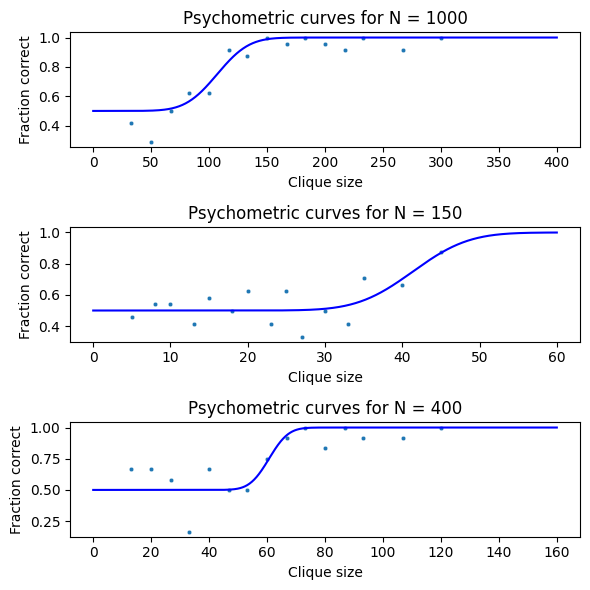

C:\Users\danie\AppData\Local\Temp\ipykernel_30632\794305606.py:297: RuntimeWarning: divide by zero encountered in log2
  K_it = 2 * np.log2(N)


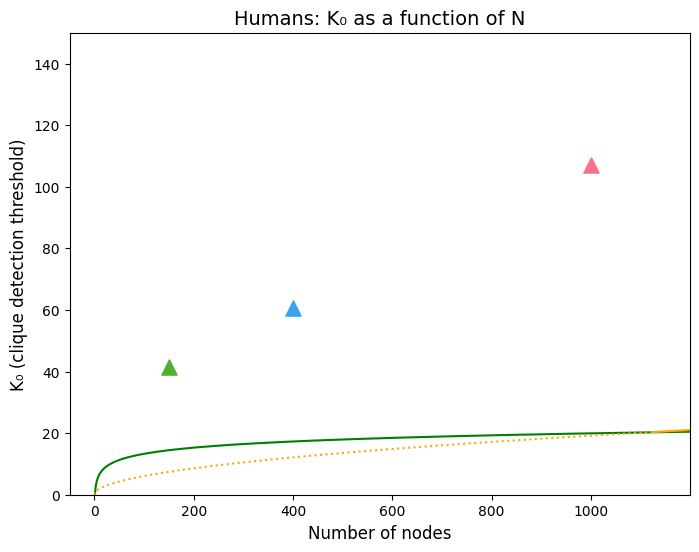

In [43]:
# Instantiate the pipeline with the experiment name
human_pipeline = HumanAnalysisPipeline(experiment_name="30-08-2024_mock-data", analysis_type="global")

# Run the entire pipeline
human_pipeline.run_human_pipeline()

# Machines:

Note: for this code to work, the 'data/machines' folder needs to contain one sub-folder for each full experiment at one value of N. Each of these folders needs to have the N value as name (ex. '150', '400'...) and must contain the results for the different models.

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# from cmcrameri import cm
# from statsmodels.formula.api import ols
from scipy.special import ndtr
from scipy.optimize import curve_fit, differential_evolution
# from scipy.stats import linregress, ttest_rel, spearmanr, shapiro, sem
# from pathlib import Path
from math import sqrt
# from math import log, e

import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

In [20]:
class MachinesAnalysisPipeline:

    def __init__(self, experiment_name):
        self.experiment_name = experiment_name

    # defining the function to calculate fitted parameters for all models
    def calculate_fitted_params(self):
        
        # defining the sigmoid function to fit to the data:
        def sigmoid(k, k0, delta):
            return (1+ndtr((k-k0)/delta))/2
    
        # go to exp folder:
        folder_path = os.path.join('..','results', 'data', self.experiment_name)
        fitted_params_df = pd.DataFrame()  # create an empty dataframe for recap
        
        #TODO:
        # - loop through all folders and read folder name (N value) -> used in final dataframe
        # - in each N folder, loop over all folders and extract fitted params for each model
        # - combine all fitted params in a single dataframe (columns: model, K0, N, Delta)
        
        # loop over all folders in the experiment folder (each folder corresponds to a model)
        for folder_name in os.listdir(folder_path):
            if os.path.isdir(os.path.join(folder_path, folder_name)):
                file_path = os.path.join(folder_path, folder_name, f'{folder_name}_N224_fraction_correct.csv')
                if os.path.isfile(file_path):
                    df_fraction_correct = pd.read_csv(file_path)
                    fitted_values = [curve_fit(sigmoid, df_fraction_correct['clique size'], df_fraction_correct['fraction correct'], p0=(70, 20))[0]]
                    fitted_params_model = pd.DataFrame(fitted_values, columns=['k0', 'delta'])
                    fitted_params_model['model'] = folder_name
                    fitted_params_df = pd.concat([fitted_params_df, fitted_params_model], ignore_index=True)
        
        print(fitted_params_df)
        self.fitted_params_df = fitted_params_df
        
    def run_machines_pipeline(self):
        self.calculate_fitted_params()
        # TODO: return a complete dataframe that can be used for general plots 
        # return machines_complete_df

In [21]:
# Instantiate the pipeline with the experiment name
machines_pipeline = MachinesAnalysisPipeline(experiment_name="2024-09-04_all-steps")

# Run the entire pipeline
machines_pipeline.run_machines_pipeline()

TypeError: MachinesAnalysisPipeline.calculate_fitted_params() missing 1 required positional argument: 'exp_name'

# Combined plot: